## Assignment 3

#### Import Required libraries

In [1]:
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import csv
import chess
import chess.pgn
import io
import re
import time
import seaborn as sns

import data_cleaning

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.metrics import roc_auc_score

import scipy.stats
from matplotlib.colors import ListedColormap

#### Import CSV file

In [2]:
chess_data = data_cleaning.import_data()

In [3]:
print(chess_data.dtypes)
print(chess_data["time_control"].unique())
# ['chess' 'chess960' 'threecheck' 'crazyhouse' 'kingofthehill']
# dunno if we should filter by chess only

# time control
#['1/259200' '1/172800' '1800' '1/86400' '1/432000' '1/604800' '600'
#  '120+1' '900+10' '300' '180+2' '3600+5' '2700+45' '3600' '1/1209600'
#  '180' '600+10' '60' '480+3' '300+5' '420+3' '600+5' '600+2' '1200' '30'
#  '60+1' '120' '1500+3' '900+2' '1500+5' '1500+10' '1/864000' '900' '300+2'
#  '1500' '7200' '300+1' '5400' '3600+60' '2700+30' '3480+45' '10' '2700+10'
#  '15' '2700' '3600+20' '4500' '4200' '900+5' '1800+10' '2700+5' '480+5'
#  '1800+30' '300+3' '600+1' '1800+5' '420+5' '5400+30' '240+10' '420' '303'
#  '60+10']
# so many types of time control -_-

# time class
# ['daily' 'rapid' 'bullet' 'blitz']

white_username    object
black_username    object
white_id          object
black_id          object
white_rating       int64
black_rating       int64
white_result      object
black_result      object
time_class        object
time_control      object
rules             object
rated               bool
fen               object
pgn               object
dtype: object
['1800' '600' '120' '900' '300' '180' '3600' '2700' '60' '480' '420'
 '1200' '30' '1500' '5400' '3480' '10' '15' '4500' '4200' '7200' '303']


In [4]:
print(len(chess_data[chess_data["time_class"] == "daily"]))
print(len(chess_data[chess_data["time_class"] == "rapid"]))
print(len(chess_data[chess_data["time_class"] == "bullet"]))
print(len(chess_data[chess_data["time_class"] == "blitz"]))

# Apply stratified sample, grouping by time class
chess_data_sample = chess_data.groupby('time_class', group_keys=False).apply(lambda x: x.sample(frac=0.2))
print(f'Number of games used in stratified sample: {len(chess_data_sample)}')

0
12012
21536
27170
Number of games used in stratified sample: 12143


#### Import chess info
https://python-chess.readthedocs.io/en/latest/core.html#chess.Board.san


#### En Passant functions
- has_legal_en_passant() tests if en passant capturing would actually be possible on the next move.
- has_pseudo_legal_en_passant()
- has_legal_en_passant()
- is_en_passant(move: Move) Checks if the given pseudo-legal move is an en passant capture.




Use StringIO to parse games from a string. Lila Use this to apply the en passant functions to for each game???

```python
import io
pgn = io.StringIO("1. e4 e5 2. Nf3 *")
game = chess.pgn.read_game(pgn)
```

#### Logistic Regression

In [5]:
# chess_data

# empty wins and ELO difference array
wins = []
wins_split = [[] for _ in range(6)]
# diffs split
# 0 to 500 | 500 to 1k | 1k to 1.5k | 1.5k to 2k | 2k to 2.5k | 2.5k+
diffs = []
diffs_split = [[] for _ in range(6)]

min_split = [10000] * 6
max_split = [0] * 6

ranges = [500, 1000, 1500, 2000, 2500, 3000]

for i in range(len(chess_data)):
    # get the ratings of each and the results
    white = chess_data["white_rating"][i]
    black = chess_data["black_rating"][i]
    result = chess_data["white_result"][i]

    # find ELO mismatch size
    diff = white - black
    avg = (white + black) // 2
    # if white wins then append 1
    binary_result = 0
    if (result == "win"):    
        binary_result = 1
    wins.append(binary_result)
    # append the elo mismatch
    diffs.append(diff)
    
    for j in range(6):
        if avg <= ranges[j]:
            diffs_split[j].append(diff)
            wins_split[j].append(binary_result)
            if diff <= min_split[j]:
                min_split[j] = diff
            if diff >= max_split[j]:
                max_split[j] = diff
            break

# set to numpy array to be able to do logistic regression
np_diffs = np.array(diffs).reshape(-1,1)
np_wins = np.array(wins)

# # fit logistic regression
# total_model = LogisticRegression().fit(np_diffs, np_wins)

# split_model = []

# # print(wins_split[0])

# for i in range(6):
#     np_diffs_split = np.array(diffs_split[i]).reshape(-1,1)
#     np_wins_split = np.array(wins_split[i])
#     split_model.append(LogisticRegression().fit(np_diffs_split, np_wins_split))

# beta0 = total_model.intercept_[0]
# beta1 = total_model.coef_[0][0]
# print("Beta 0: " + str(beta0) + ", Beta 1: " + str(beta1))





# Split into training and testing sets
diffs_train, diffs_test, wins_train, wins_test = train_test_split(np_diffs, np_wins, test_size=0.2)


# fit logistic regression
total_model = LogisticRegression().fit(diffs_train, wins_train)

split_model = []

# print(wins_split[0])

for i in range(6):
    np_diffs_split = np.array(diffs_split[i]).reshape(-1,1)
    np_wins_split = np.array(wins_split[i])
    split_model.append(LogisticRegression().fit(np_diffs_split, np_wins_split))

beta0 = total_model.intercept_[0]
beta1 = total_model.coef_[0][0]
print("Beta 0: " + str(beta0) + ", Beta 1: " + str(beta1))

# Apply model to test set
test_predictions = total_model.predict(diffs_test)
print('AUC score: ', roc_auc_score(test_predictions, wins_test))

Beta 0: 0.06758040180275161, Beta 1: 0.010837373544037925
AUC score:  0.707096897122035


### Wald statistics for Hypothesis test

Gives bad value??? For linear regression instead?

https://www.sciencedirect.com/topics/mathematics/wald-test

import math

def standard_error():
    '''
    Finds standard error of a slope.

    Uses method to find standard error from: https://sciencing.com/calculate-standard-error-slope-8135202.html (accessed 02.04.2023).

    This method is hard-coded to take values from existing variables elsewhere in the code.

    Important variables:
    predict_prob_win = Matrix of what the model predicts the probability of winning is for each game's white player.
    np_wins = Matrix of the actual outcome of each game for the white player.
    diffs = How many ELO points the white player is ahead of the black player.
    '''
    # Generate matrix of predicted probabilities of winning
    predict_prob_win = total_model.predict_proba(np_diffs)[:,1]

    # Find sum of square residuals (differences between predicted and actual outcomes, squared)
    square_residuals = (predict_prob_win - np_wins) ** 2
    SSR = sum(square_residuals.tolist())

    # Divide sum of square residuals by number of data points minus 2, and take the square root
    SSR_divided = math.sqrt(SSR / (len(np_wins) - 2))

    # Find explained sum of squares of least ELO
    ESS = math.sqrt(sum(((diffs - np.mean(diffs)) ** 2).tolist()))

    # Divide ESS by SSR to get standard error of the slope
    stand_error = ESS / SSR

    return stand_error

def wald_statistic(beta_1):
    '''
    Returns the Wald statistic, calculated by: beta_1 / (standard error of beta_1).
    '''
    return beta_1 / standard_error()

wald = wald_statistic(beta1)

print(f'Standard error: {standard_error()}')
print(f'Wald statistic: {wald_statistic(beta1)}')
p_val = 1 - (scipy.stats.norm(0, 1).cdf(wald))
print(p_val)

In [6]:
### Rest of the code in this cell is heavily influenced by:
# https://stats.stackexchange.com/questions/89484/how-to-compute-the-standard-errors-of-a-logistic-regressions-coefficients

# Generate predicted-probability matrix
predict_prob = total_model.predict_proba(np_diffs)

# Add 1's column at start of np_diffs matrix
np_diffs_1s = np.hstack([np.ones((np_diffs.shape[0], 1)), np_diffs])

# Initialise 0's matrix
# Insert diagonal entries containing variance of predictions
# V = np.diagflat(np.product(predict_prob, axis=1))
# V = np.diagflat(np.multiply(predict_prob[:,0], predict_prob[:,1]))
V = np.multiply(predict_prob[:,0], predict_prob[:,1])
# Find covariances matrix
# cov_matrix = np.linalg.inv(np_diffs_1s.T @ V @ np_diffs_1s)
cov_matrix = np.linalg.pinv(np.dot(np_diffs_1s.T * V, np_diffs_1s))
# Find standard errors
standard_errors = np.sqrt(np.diag(cov_matrix))

# Find Wald statistic (coefficients / standard error) ^ 2
total_model_stats = np.insert(total_model.coef_, 0, total_model.intercept_)
wald_stats =  (total_model_stats / standard_errors) ** 2

# Find p-value
p_val = 2 * (1 - (scipy.stats.norm(0, 1).cdf(wald_stats[0])))

print(f'Covariance matrix: {cov_matrix}')
print(f'Total model stats: {total_model_stats}')
print(f'Standard errors: {standard_errors}')
print(f'Wald statistics: {wald_stats}')

print(f'p-val: {p_val}')

Covariance matrix: [[7.72759862e-05 1.58025214e-08]
 [1.58025214e-08 2.06946076e-08]]
Total model stats: [0.0675804  0.01083737]
Standard errors: [0.00879068 0.00014386]
Wald statistics: [  59.1012931 5675.3269936]
p-val: 0.0


In [7]:
print(beta1)

0.010837373544037925


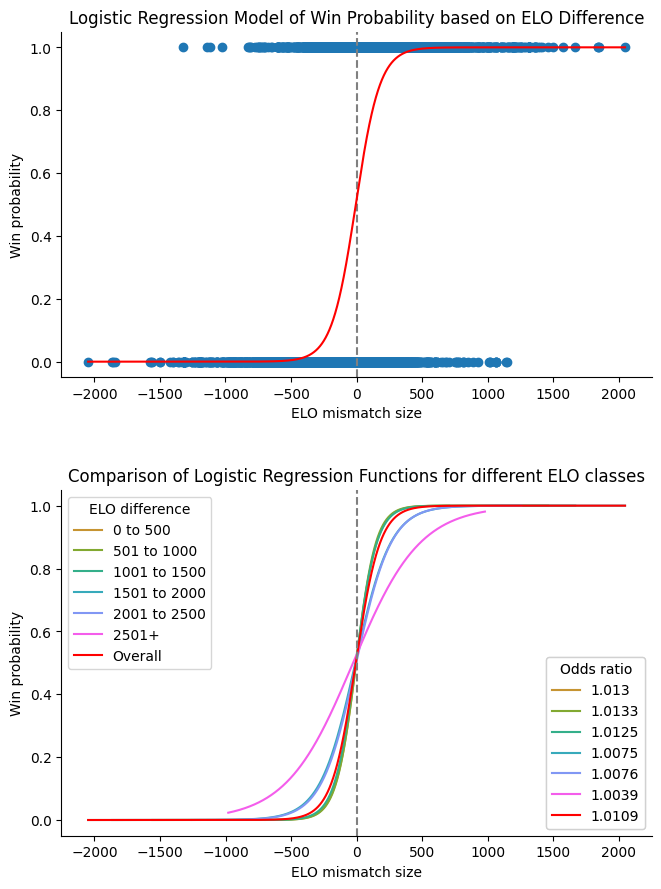

In [18]:
fig, ax1 = plt.subplots(2, 1, figsize=(8,10))
fig.tight_layout(pad=6.0)
# binary scatter plot
ax1[0].scatter(diffs, wins)
plt.setp(ax1, xticks=(np.arange(-2000, 2500, 500))) # Set tick labels

# np.arange for the range of values in the difference of ELO
x = np.arange(np_diffs.min(), np_diffs.max(), 0.1)
ax1[0].axvline(x = 0, color="gray", linestyle="dashed")

# plot logistic regression estimator
ax1[0].plot(x, total_model.predict_proba(np.reshape(x, (-1, 1)))[:,1], color="red")
ax1[0].set_title("Logistic Regression Model of Win Probability based on ELO Difference", fontsize=12)
ax1[0].set_xlabel("ELO mismatch size")
ax1[0].set_ylabel("Win probability")
ax1[0].spines[['right', 'top']].set_visible(False)

# Initialise array to record beta_1 for each logistic regression function
odds_ratio_array = [None] * 7
odds_ratio_array[6] = round(np.exp(beta1), 4)

cmap = sns.color_palette("husl", 7)
# cmap = ListedColormap(sns.color_palette("colorblind"))
labels = ["0 to 500", "501 to 1000", "1001 to 1500",
          "1501 to 2000", "2001 to 2500", "2501+", "Overall"]
for i in range(6):
    x = np.arange(min_split[i], max_split[i], 0.1)
    ax1[1].plot(x, split_model[i].predict_proba(np.reshape(x, (-1, 1)))[:,1],
                color=cmap[i+1], label=labels[i])
    beta_1 = split_model[i].coef_[0][0]
    odds_r = np.exp(beta_1)
    odds_ratio_array[i] = round(odds_r, 4)

x = np.arange(np_diffs.min(), np_diffs.max(), 0.1)
ax1[1].spines[['right', 'top']].set_visible(False)
ax1[1].plot(x, total_model.predict_proba(np.reshape(x, (-1, 1)))[:,1], color="red", label=labels[6])
ax1[1].axvline(x = 0, color="gray", linestyle="dashed")
ax1[1].set_title("Comparison of Logistic Regression Functions for different ELO classes")
ax1[1].set_xlabel("ELO mismatch size")
ax1[1].set_ylabel("Win probability")

legend_elo = plt.legend(title="ELO difference" , loc="upper left")
legend_beta1 = plt.legend(odds_ratio_array, title="Odds ratio", loc="lower right")
ax1[1].add_artist(legend_elo)
ax1[1].add_artist(legend_beta1)

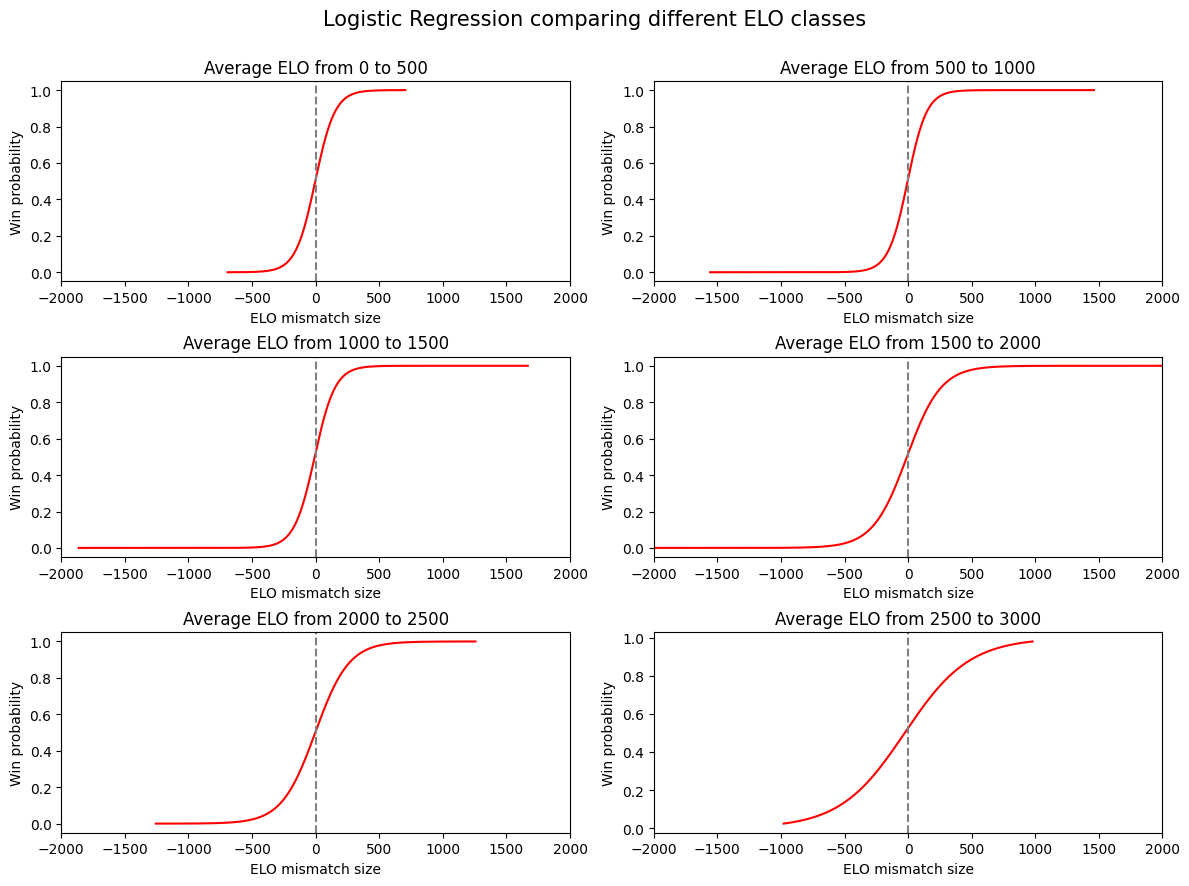

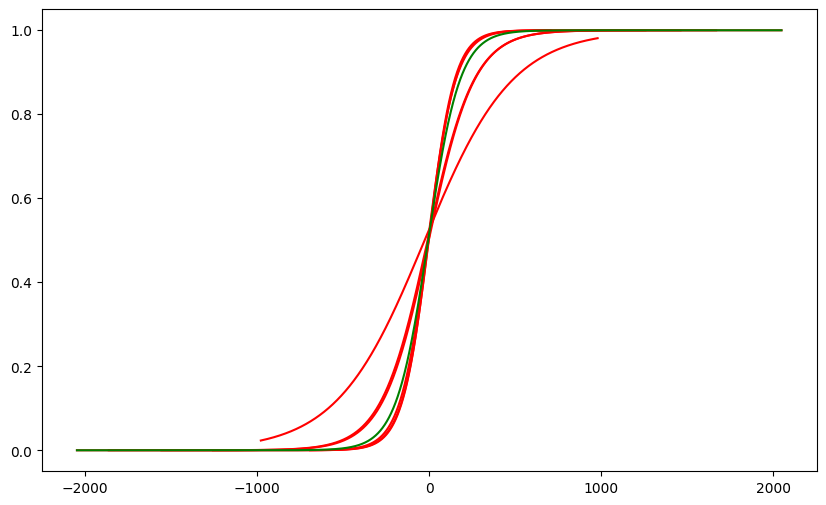

In [9]:
fig2, ax2 = plt.subplots(3,2,figsize=(12,9))
# binary scatter plot

# np.arange for the range of values in the difference of ELO

# plot logistic regresion estimator

for i in range(6):
    x = np.arange(min_split[i], max_split[i], 0.1)
    ax2[i//2][i%2].plot(x, split_model[i].predict_proba(np.reshape(x, (-1, 1)))[:,1], color="red")
    
    ax2[i//2][i%2].axvline(x = 0, color="gray", linestyle="dashed")
    ax2[i//2][i%2].set_xlabel("ELO mismatch size")
    ax2[i//2][i%2].set_ylabel("Win probability")
    ax2[i//2][i%2].set_xlim([-2000, 2000])
    ax2[i//2][i%2].set_title("Average ELO from "+ str(ranges[i]-500) + " to " + str(ranges[i]))

fig2.tight_layout()
fig2.suptitle("Logistic Regression comparing different ELO classes", fontsize=15)
fig2.subplots_adjust(top=0.9)

fig2, ax3 = plt.subplots(figsize=(10,6))
for i in range(6):
    x = np.arange(min_split[i], max_split[i], 0.1)
    ax3.plot(x, split_model[i].predict_proba(np.reshape(x, (-1, 1)))[:,1], color="red")

x = np.arange(np_diffs.min(), np_diffs.max(), 0.1)
ax3.plot(x, total_model.predict_proba(np.reshape(x, (-1, 1)))[:,1], color="green")

### Beta 0

Beta 0 is the log odds of a win with 0 difference in ELO between 2 players.

To find the probability of a win when there is 0 difference in ELO we use the formula:
f(beta0) = 1/(1 + exp(beta0)).

### Beta 1

Beta 1 describes the increase in the log odds when ELO is increased by 1 point - ie for every increase in ELO by 1, the log odds are multiplied by a factor of exp(beta1).

Odds ratio = OR = exp(beta1)

In [10]:
def prob_win_same_elo(beta_0):
    '''
    Returns probability of a win with 0 difference in ELO between 2 players.
    '''
    return 1 / (1 + np.exp(beta_0))

def odds_ratio(beta_1):
    '''
    Returns odds ratio.
    '''
    return np.exp(beta_1)


print(f' Log odds of a win with 0 difference in ELO: {beta0} logits')
print(f' Probability of a win with 0 difference in ELO: {prob_win_same_elo(beta0)}')
print(f' Increase in log odds for every increase by 1 ELO point: {odds_ratio(beta1)}')

 Log odds of a win with 0 difference in ELO: 0.06758040180275161 logits
 Probability of a win with 0 difference in ELO: 0.483111326763463
 Increase in log odds for every increase by 1 ELO point: 1.0108963105918867


### Interpretation

Log odds is close to 0 (0.07679 logits, 5dp), meaning that winning and losing are almost equally as likely for players with the same ELO.

This is supported by the probability of a win being close to 0.5 (0.48081, 5dp).

The odds ratio is 1.01033 meaning for every 1 point increase in ELO a player is 1.01033 more likely to win.

### Principle of maximum likelihood

Definition from lecture notes: PML 'states that we adjust the model coefficients so as to maximise the likelihood that the observed data arises from the model.'

PML assumes independent datapoints.

PML is used to generate the red line in the logistic regression graph.

### Wald Statistic
 The Wald statistic is defined as (e.g. Wasserman (2006): All of Statistics, pages 153, 214-215):
 https://stats.stackexchange.com/questions/60074/wald-test-for-logistic-regression


### Hypothesis Tests for Beta 1

Testing for relationship between ELO and probability of a win

H0: beta1 = 0 (no statistically significant relationship)

Ha: beta1 != 0 (is a statistically significant relationship)


### Test procedure

- Find test statistic (number of wins???)
- Determine distribution of null hypothesis 



- Use z-test to find p-values
- Find p-values (assume H0 is true then find probability of getting the data we have)
- If p value is less than 5%, reject null hypothesis